/tmp/ipykernel_27685/983586767.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


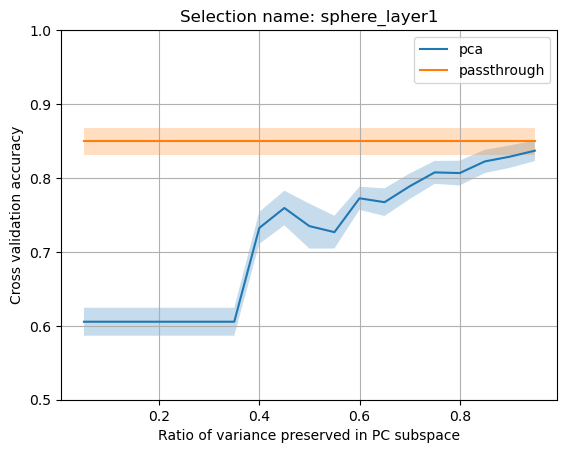

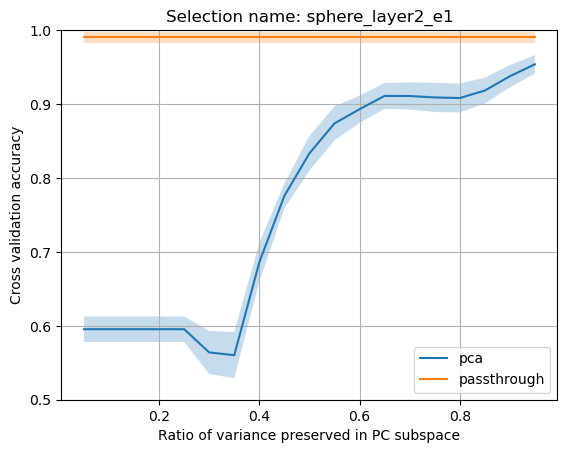

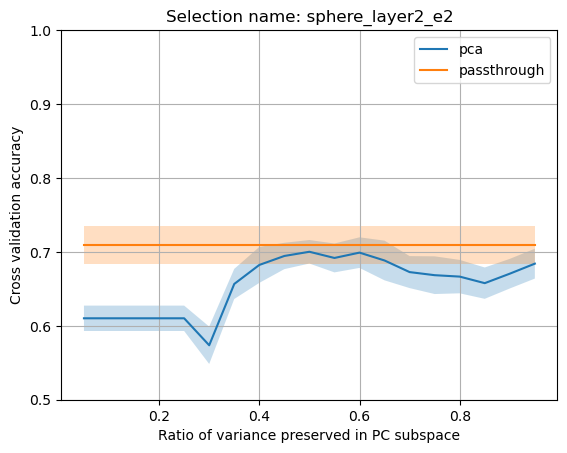

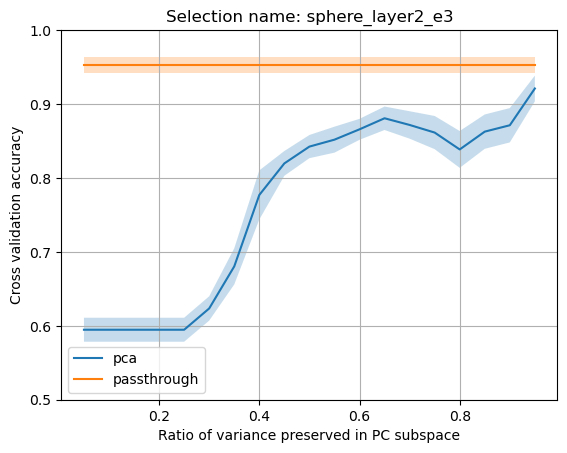

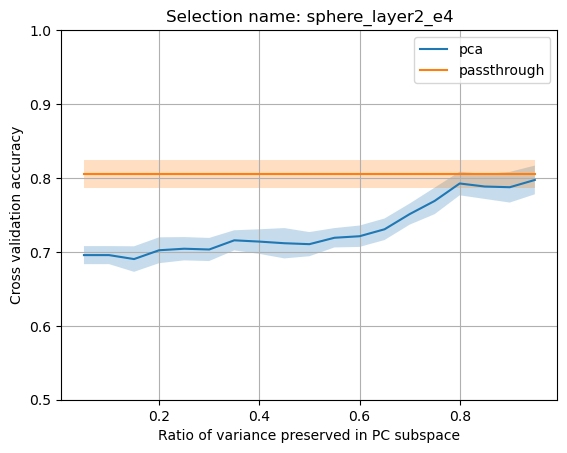

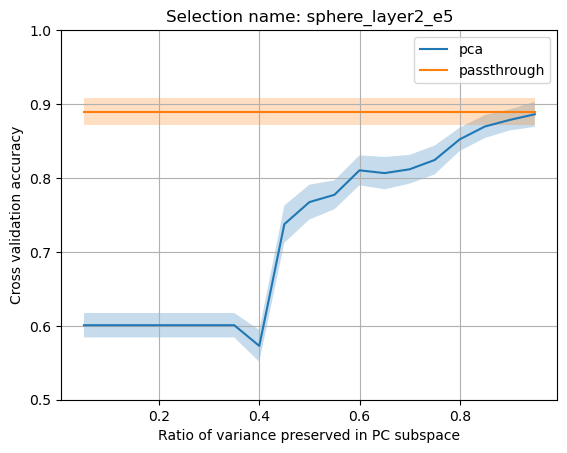

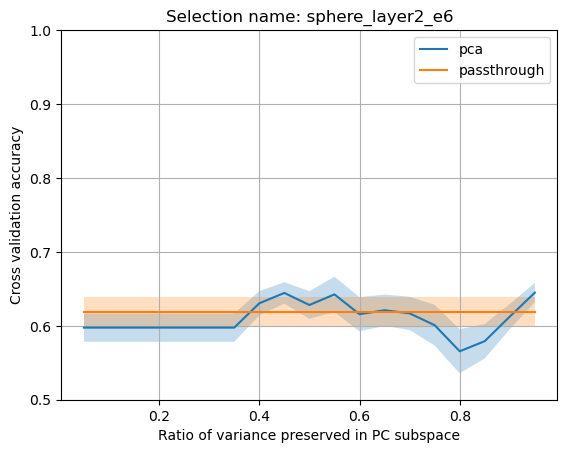

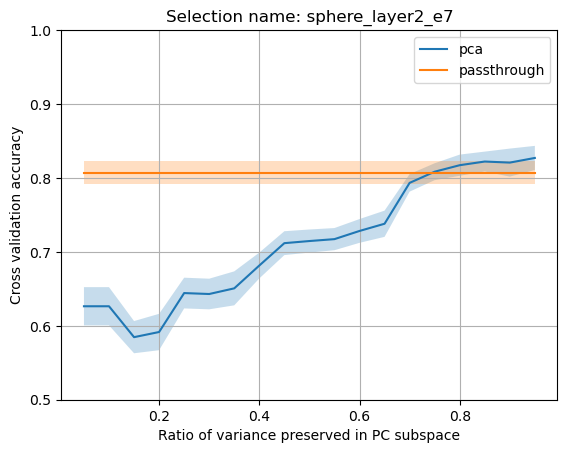

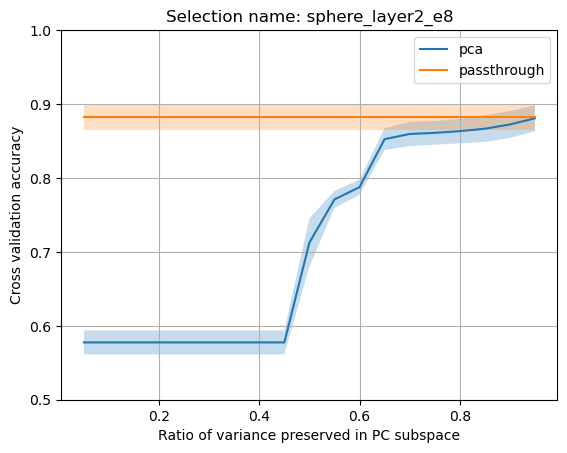

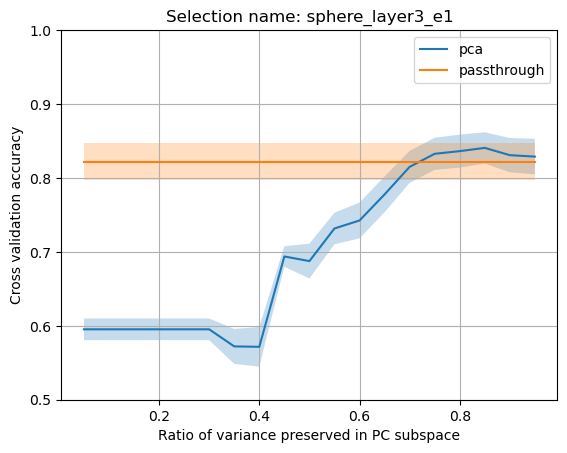

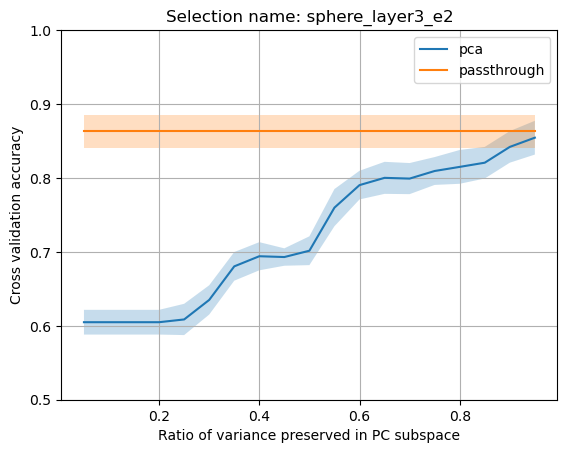

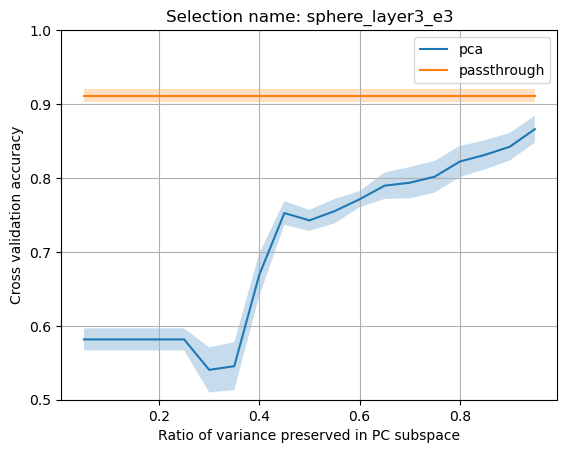

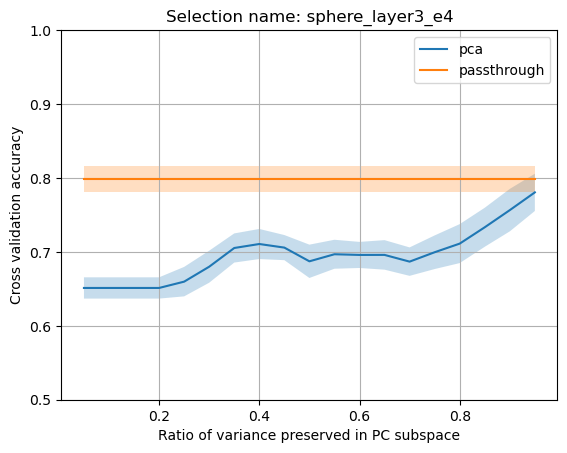

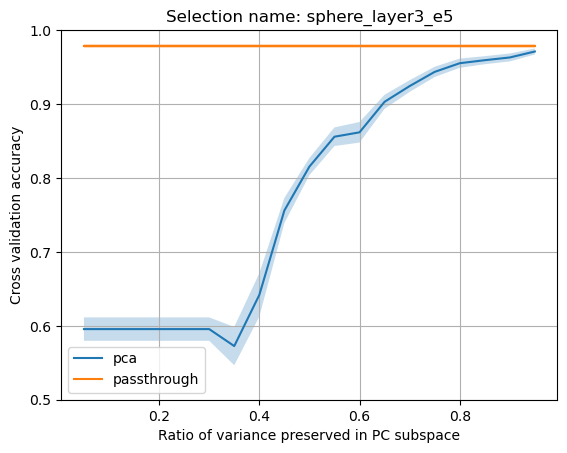

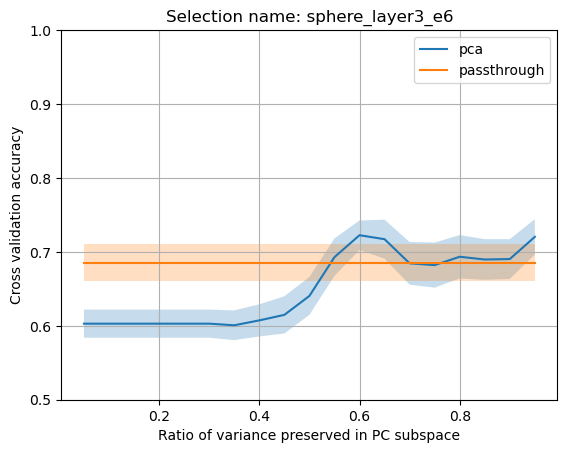

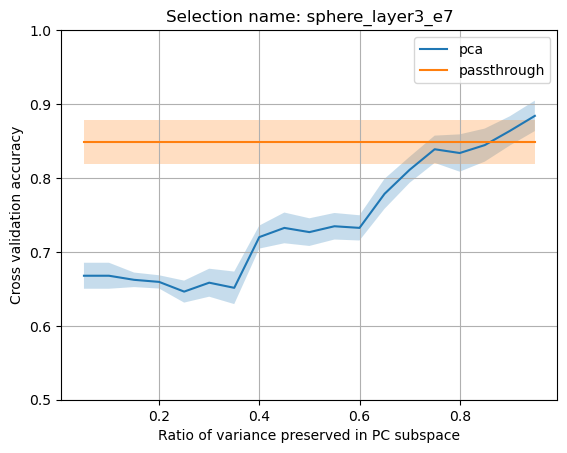

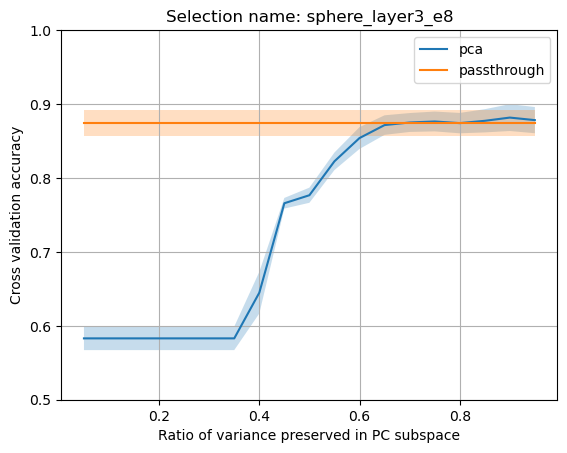

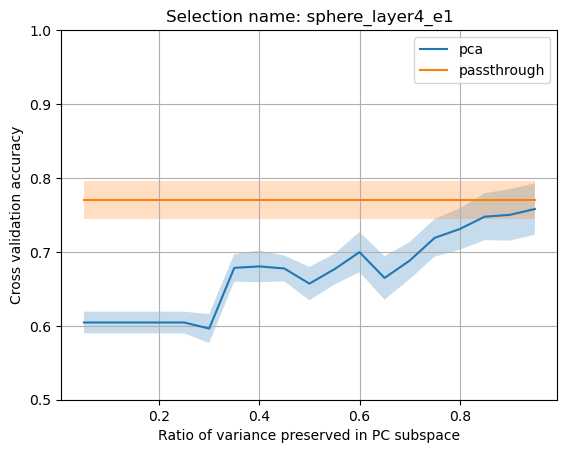

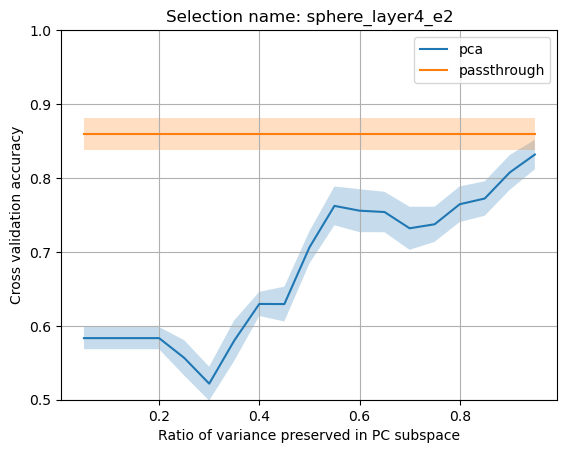

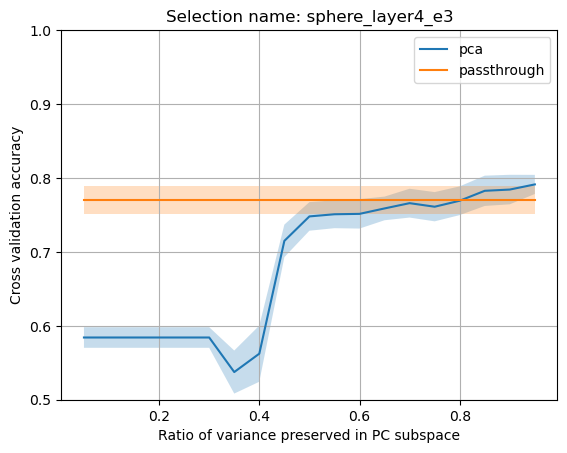

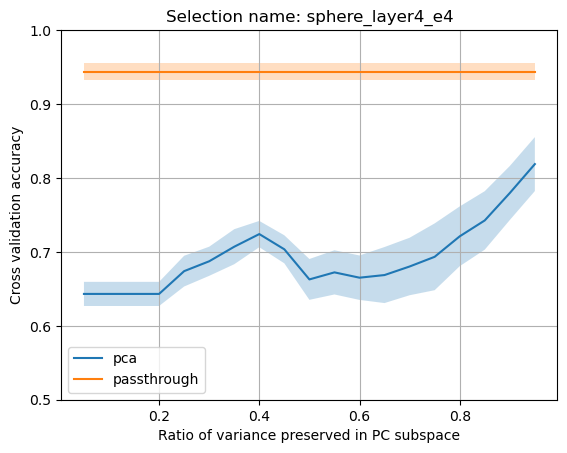

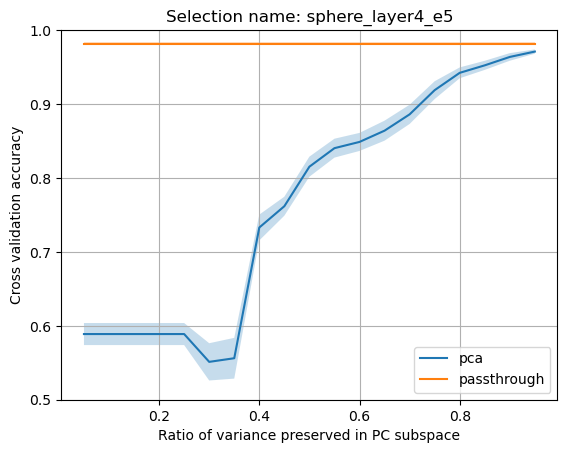

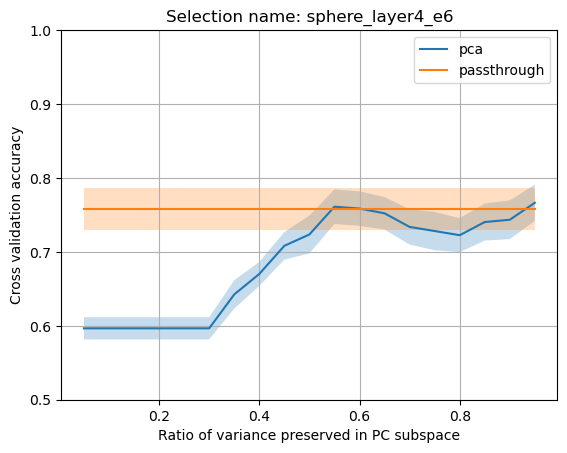

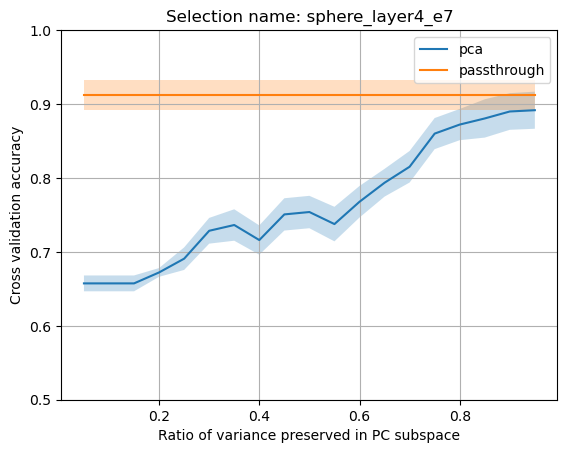

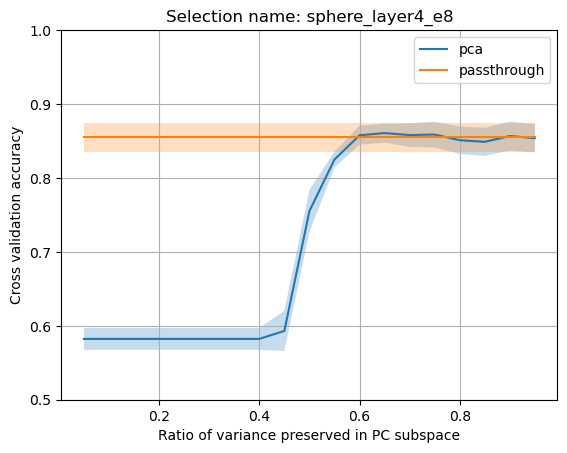

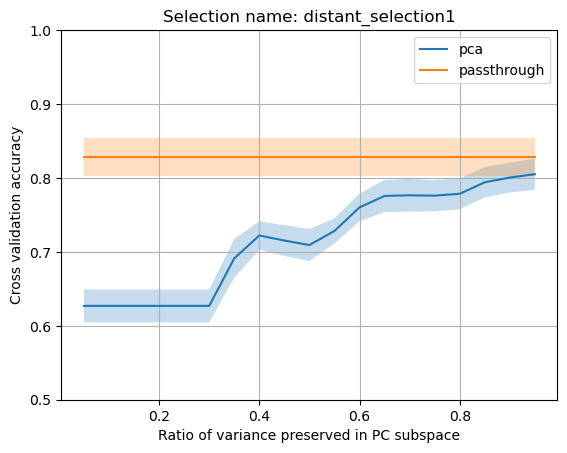

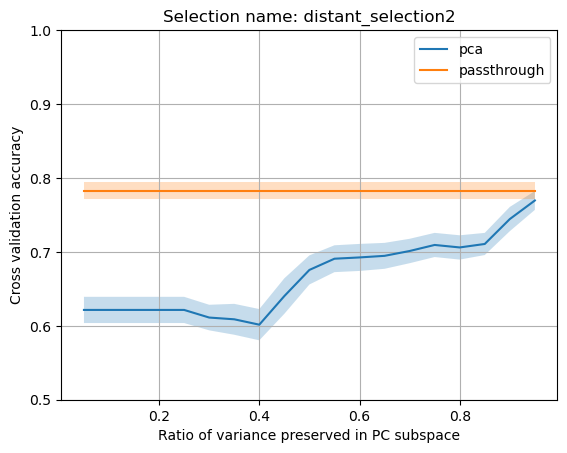

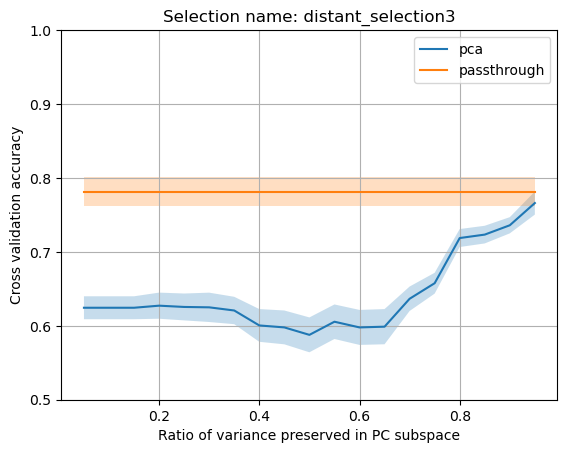

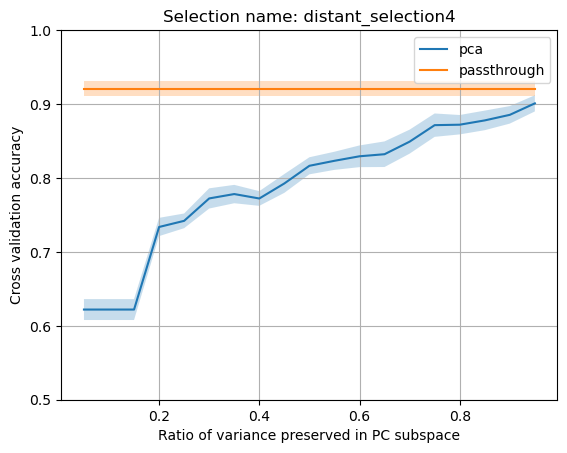

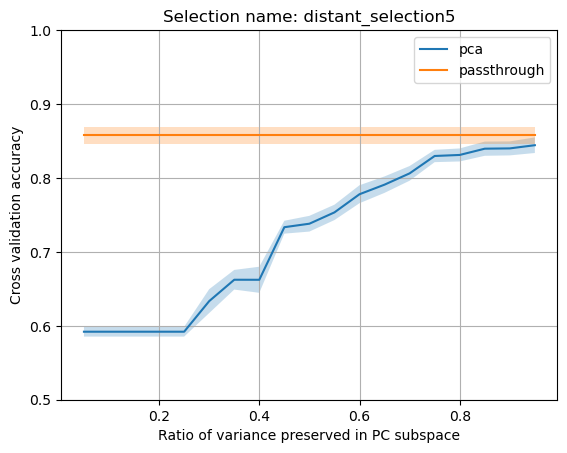

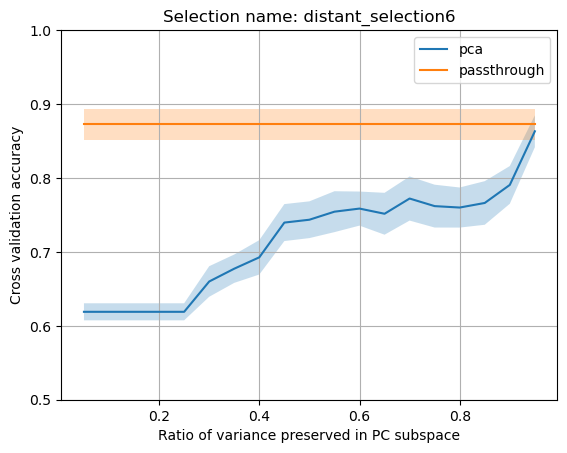

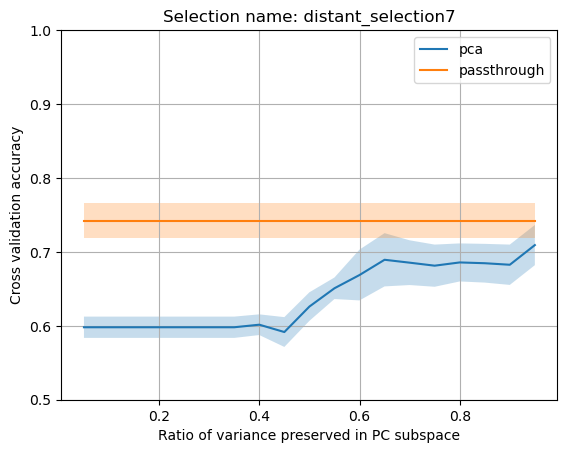

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import shared_data as sd
import utility_functions as uf
from glob import glob

alpha_value = 0.25
partition_name = "validation"
pair_name = "LNC_NONE"
def get_sorting_key(result_file_path):
    return int(result_file_path.split("_")[-1].strip(".npy"))
for selection_name in sd.SELECTION_DICT:
    result_file_paths = glob(f"{sd.RESULTS}/*{pair_name}*{selection_name}*{partition_name}*")
    result_file_paths = sorted(result_file_paths, key=get_sorting_key)
    result_dict = {
        "pca": {"n_components": [], "accuracy_mean": [], "accuracy_sem": []},
        # "tica": {f"{lag}": {"accuracy_mean": [], "accuracy_sem": []} for lag in sd.DIM_REDUCTION_HPS["tica"]["lag"]}
    }
    for result_file_path in result_file_paths:
        cf = uf.get_config_file_from_file_path(result_file_path)
        accuracy_mean, accuracy_sem = uf.get_accuracy_mean_and_sem(result_file_path)
        if cf.dim_reduction_name == "passthrough":
            result_dict[cf.dim_reduction_name] = {
                "n_components": sd.DIM_REDUCTION_HPS["pca"]["n_components"],
                "accuracy_mean": [accuracy_mean for _ in sd.DIM_REDUCTION_HPS["pca"]["n_components"]], 
                "accuracy_sem": [accuracy_sem for _ in sd.DIM_REDUCTION_HPS["pca"]["n_components"]],
            }
        elif cf.dim_reduction_name == "pca":
            result_dict[cf.dim_reduction_name]["n_components"].append(cf.config_dict["dim_reduction"]["pca"]["n_components"])
            result_dict[cf.dim_reduction_name]["accuracy_mean"].append(accuracy_mean)
            result_dict[cf.dim_reduction_name]["accuracy_sem"].append(accuracy_sem)

        # else:
        #     result_dict[cf.dim_reduction_name][str(cf.config_dict["dim_reduction"]["tica"]["lag"])]["accuracy_mean"].append(accuracy_mean)
        #     result_dict[cf.dim_reduction_name][str(cf.config_dict["dim_reduction"]["tica"]["lag"])]["accuracy_sem"].append(accuracy_sem)    
    plt.figure()
    plt.title(f"Selection name: {selection_name}")
    for dim_reduction_name, dim_reduction_results in result_dict.items():
        plt.plot(result_dict[dim_reduction_name]["n_components"], result_dict[dim_reduction_name]["accuracy_mean"], label=dim_reduction_name)
        plt.fill_between(result_dict[dim_reduction_name]["n_components"], 
                        np.subtract(result_dict[dim_reduction_name]["accuracy_mean"], result_dict[dim_reduction_name]["accuracy_sem"]), 
                        np.add(result_dict[dim_reduction_name]["accuracy_mean"], result_dict[dim_reduction_name]["accuracy_sem"]),
                        alpha=alpha_value)
    plt.ylim((0.5, 1))
    plt.ylabel("Cross validation accuracy")
    plt.xlabel("Ratio of variance preserved in PC subspace")
    plt.legend()
    plt.grid()